# Plot Task Latencies
This notebook plots the latencies between consecutive tasks.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.interpolate import interp1d
from collections import defaultdict
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import json
import re
import gzip
import os

## Plot Generated Ligand to Queue Latency

In [2]:
def get_process_ligands_latencies(run_dir: Path) -> pd.DataFrame:
    path = run_dir / "generation-results.json"
    task_dicts = []
    with open(path) as fp:
        for line in fp:
            row = json.loads(line)
            if row["method"] != "process_ligands":
                continue
            if "process_done" not in row["task_info"]:
                # Task failed
                continue
            task_dicts.append(
                {
                    "method": row["method"],
                    "ligand_id": row["task_info"]["task"][0],
                    "ligand_size": row["task_info"]["task"][1],
                    "model_version": row["task_info"]["model_version"],
                    "process_end_time": row["task_info"]["process_done"],
                    "generated_time": row["timestamp"]["created"],
                    "latency": row["task_info"]["process_done"]
                    - row["timestamp"]["created"],
                }
            )
    return pd.DataFrame(task_dicts)

In [3]:
DATE_PATTERN = "\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}"
PATTERN = re.compile(f"({DATE_PATTERN}).*mof=(mof-[a-z0-9]*):")


def get_sim_result_latencies(run_dir: Path) -> pd.DataFrame:
    sim_path = run_dir / "simulation-results.json"
    log_path = run_dir / "run.log"

    db_create = {}

    pattern = r""
    with open(log_path) as fp:
        for line in fp:
            if "Lattice change after MD simulation" in line:
                match = PATTERN.match(line)
                if match is None:
                    print(line)
                    raise AssertionError
                name = match.group(2)
                create_date = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
                create_timestamp = datetime.timestamp(create_date)
                db_create[name] = create_timestamp

    task_dicts = []
    with open(sim_path) as fp:
        for line in fp:
            row = json.loads(line)
            if row["method"] != "run_molecular_dynamics":
                continue
            if not row["success"]:
                continue
            name = row["task_info"]["name"]
            write_time = db_create[name] if name in db_create else None
            latency = (
                write_time - row["timestamp"]["compute_ended"]
                if write_time is not None
                else None
            )
            task_dicts.append(
                {
                    "method": row["method"],
                    "name": name,
                    "simulation_end_time": row["timestamp"]["compute_ended"],
                    "database_write_time": write_time,
                    "latency": latency,
                }
            )

    return pd.DataFrame(task_dicts)

In [4]:
def get_retrain_latencies(run_dir: Path) -> pd.DataFrame:
    generate_path = run_dir / "generation-results.json"
    model_version_uses = defaultdict(list)
    with open(generate_path) as fp:
        for line in fp:
            row = json.loads(line)
            if row["method"] != "run_generator":
                continue
            model_version = row["task_info"]["model_version"]
            start_time = row["timestamp"]["compute_started"]
            model_version_uses[model_version].append(start_time)
    model_version_first_use = {
        key: min(values) for key, values in model_version_uses.items()
    }

    train_path = run_dir / "training-results.json"
    task_dicts = []
    model_index = 1
    with open(train_path) as fp:
        for line in fp:
            row = json.loads(line)
            if not row["success"]:
                continue

            available = row["timestamp"]["result_received"]
            if model_index in model_version_first_use:
                first_use = model_version_first_use[model_index]
            else:
                first_use = None
            task_dicts.append(
                {
                    "method": row["method"],
                    "model_version": model_index,
                    "result_received": available,
                    "first_generation_start": first_use,
                    "latency": first_use - available if first_use is not None else None,
                }
            )
            model_index += 1

    return pd.DataFrame(task_dicts)

In [5]:
def get_mof_latencies(run_dir: Path) -> pd.DataFrame:
    simulate_path = run_dir / "simulation-results.json"

    mof_events = defaultdict(dict)
    with open(simulate_path) as fp:
        for line in fp:
            row = json.loads(line)

            try:
                mof_name = row["task_info"]["name"]
            except:
                mof_name = row["task_info"]["mof"]

            method = row["method"]
            if method == "run_optimization":
                mof_events[mof_name]["run_optimization_done"] = row["timestamp"][
                    "compute_ended"
                ]
            elif method == "compute_partial_charges":
                mof_events[mof_name]["compute_partial_charges_start"] = row[
                    "timestamp"
                ]["compute_started"]
                mof_events[mof_name]["compute_partial_charges_done"] = row["timestamp"][
                    "compute_ended"
                ]
            elif method == "run_GCMC_single":
                mof_events[mof_name]["run_GCMC_single_start"] = row["timestamp"][
                    "compute_started"
                ]

    mof_events = [{"name": name, **events} for name, events in mof_events.items()]

    data = pd.DataFrame(mof_events)
    data["compute_partial_charges_latency"] = (
        data["compute_partial_charges_start"] - data["run_optimization_done"]
    )
    data["run_GCMC_single_latency"] = (
        data["run_GCMC_single_start"] - data["compute_partial_charges_done"]
    )

    return data

In [6]:
def plot_latency_distributions(run_dir):
    process_ligands_tasks = get_process_ligands_latencies(run_dir)
    sim_tasks = get_sim_result_latencies(run_dir)
    retrain_tasks = get_retrain_latencies(run_dir)
    mof_tasks = get_mof_latencies(run_dir)

    latencies = {
        "RDKit/OpenBabel": process_ligands_tasks["latency"].dropna().to_list(),
        "LAMMPS": sim_tasks["latency"].dropna().to_list(),
        "DiffLinker Train": retrain_tasks["latency"].dropna().to_list(),
        "Chargemol": mof_tasks["compute_partial_charges_latency"].dropna().to_list(),
        "RASPA": mof_tasks["run_GCMC_single_latency"].dropna().to_list(),
    }

    fig, ax = plt.subplots(figsize=(3.5, 2.25))

    # rectangular box plot
    bplot = ax.boxplot(
        list(reversed(latencies.values())),
        labels=list(reversed(latencies.keys())),
        vert=False,
    )
    ax.set_xlabel("Time (s)")

    plt.show()

/var/folders/kn/2_n0f_tn41j9_rj_8lcvx4g00000gn/T/ipykernel_20852/772852710.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


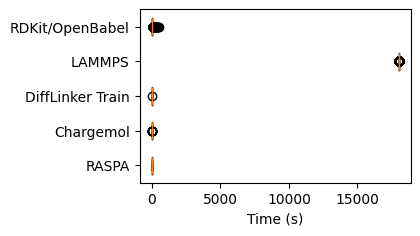

In [7]:
run_dir = Path("../prod-runs/128-nodes/")
plot_latency_distributions(run_dir)

In [31]:
def gather_scaling_latencies(run_dirs, stddev=True):
    latencies = []
    stddevs = []

    for nodes, path in tqdm(run_dirs.items()):
        if isinstance(nodes, Path):
            nodes = int(nodes.name.split("-")[0])

        print(path)
        process_ligands_tasks = get_process_ligands_latencies(path)
        sim_tasks = get_sim_result_latencies(path)
        retrain_tasks = get_retrain_latencies(path)
        mof_tasks = get_mof_latencies(path)

        process_ligands_latencies = process_ligands_tasks["latency"].dropna()
        sim_latencies = sim_tasks["latency"].dropna()
        retrain_latencies = (
            retrain_tasks["latency"].dropna()
            if len(retrain_tasks) > 0
            else np.array([])
        )
        compute_partial_latencies = mof_tasks[
            "compute_partial_charges_latency"
        ].dropna()
        run_gcmc_latencies = mof_tasks["run_GCMC_single_latency"].dropna()

        latencies.append(
            {
                "nodes": nodes,
                "path": path.name,
                "RDKit/OpenBabel": process_ligands_latencies.mean(),
                "LAMMPS": sim_latencies.mean(),
                "DiffLinker Train": retrain_latencies.mean(),
                "Chargemol": compute_partial_latencies.mean(),
                "RASPA": run_gcmc_latencies.mean(),
            }
        )

        if stddev:
            stddevs.append(
                {
                    "nodes": nodes,
                    "path": path.name,
                    "RDKit/OpenBabel": process_ligands_latencies.std(),
                    "LAMMPS": sim_latencies.std(),
                    "DiffLinker Train": retrain_latencies.std(),
                    "Chargemol": compute_partial_latencies.std(),
                    "RASPA": run_gcmc_latencies.std(),
                }
            )
        else:
            stddevs.append(
                {
                    "nodes": nodes,
                    "path": path.name,
                    "RDKit/OpenBabel": (
                        np.quantile(process_ligands_latencies, 0.25),
                        np.quantile(process_ligands_latencies, 0.75),
                    ),
                    "LAMMPS": (
                        np.quantile(sim_latencies, 0.25),
                        np.quantile(sim_latencies, 0.75),
                    ),
                    "DiffLinker Train": (
                        np.quantile(retrain_latencies, 0.25),
                        np.quantile(retrain_latencies, 0.75),
                    ),
                    "Chargemol": (
                        np.quantile(compute_partial_latencies, 0.25),
                        np.quantile(compute_partial_latencies, 0.75),
                    ),
                    "RASPA": (
                        np.quantile(run_gcmc_latencies, 0.25),
                        np.quantile(run_gcmc_latencies, 0.75),
                    ),
                }
            )

    latencies_df = pd.DataFrame(latencies).sort_values("nodes")
    stddevs_df = pd.DataFrame(stddevs).sort_values("nodes")
    return latencies_df, stddevs_df

In [ ]:
def make_scaling_plot(latencies, stddevs, logy=False):
    nodes = sorted(latencies["nodes"].to_list())
    fig, ax = plt.subplots(figsize=(3.5, 2))
    print(nodes)

    # Drop the "nodes" and "path" column names
    kinds = list(latencies.keys())[2:]

    linestyles = ["-", "--", ":", "-.", (0, (3, 5, 1, 5, 1, 5))]
    markerstyles = ["o", "^", "v", "s", "d"]

    for i, kind in enumerate(kinds):
        err = pd.DataFrame(stddevs[kind].to_list()).transpose()
        ax.errorbar(
            # x=[x*(1 + 0.03*i) for x in latencies['nodes']],
            x=latencies["nodes"],
            y=latencies[kind],
            yerr=err,
            label=kind,
            # linestyle=linestyles[i],
            marker=markerstyles[i],
            capsize=2,
            elinewidth=0.75,
        )

    ax.set_ylabel("Latency (sec)", fontsize=8.5)
    ax.set_xlabel("Nodes", fontsize=8.5)
    if logy:
        ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=2)
    # ax.set_ylim([0, 60])

    handles, labels = ax.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # ax.legend(loc='upper center', fontsize=8, bbox_to_anchor=(0.5, -0.25), ncols=2)
    if not logy:
        ax.set_xticks(nodes)
        ax.set_xticklabels(nodes)
        ax.legend(
            handles, labels, loc="upper right", fontsize=6, bbox_to_anchor=(1.01, 1.01)
        )
    else:
        ax.set_yticks([0.01, 0.1, 1, 10, 100])
        ax.legend(
            handles,
            labels,
            loc="lower left",
            fontsize=6,
            bbox_to_anchor=(0, 0),
            ncols=2,
        )

    ax.tick_params(axis="x", labelsize=7)
    ax.tick_params(axis="y", labelsize=7)

    return fig

In [25]:
prod_runs_dir = Path("../prod-runs/")
prod_runs = {}
for d in prod_runs_dir.glob("*-nodes*"):
    nodes = int(d.name.split("-")[0])
    prod_runs[d] = d.absolute()

latencies, stddevs = gather_scaling_latencies(prod_runs, stddev=True)
latencies.head()

 17%|█▋        | 2/12 [00:03<00:18,  1.81s/it]/var/folders/kn/2_n0f_tn41j9_rj_8lcvx4g00000gn/T/ipykernel_20852/3118432788.py:32: RuntimeWarning: Mean of empty slice.
  "DiffLinker Train": retrain_latencies.mean(),
/Users/Nathaniel/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/Nathaniel/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Nathaniel/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/Nathaniel/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount

,nodes,path,RDKit/OpenBabel,LAMMPS,DiffLinker Train,Chargemol,RASPA
4,32,32-nodes_no-retrain,14.040884,18000.058084,NaN,0.367635,4.320696
5,32,32-nodes_repeat-1,25.464398,18000.061779,42.362898,1.128161,2.694254
11,32,32-nodes_repeat-2,16.521900,18000.058107,33.365839,0.395319,4.428928
0,64,64-nodes_repeat-2,18.436499,18000.060210,20.317799,0.668386,2.277868
2,64,64-nodes_no-stream,103.116890,18000.062349,NaN,2.635761,2.967038


In [11]:
latencies

,nodes,path,RDKit/OpenBabel,LAMMPS,DiffLinker Train,Chargemol,RASPA
4,32,32-nodes_no-retrain,14.040884,18000.058084,NaN,0.367635,4.320696
5,32,32-nodes_repeat-1,25.464398,18000.061779,42.362898,1.128161,2.694254
11,32,32-nodes_repeat-2,16.521900,18000.058107,33.365839,0.395319,4.428928
0,64,64-nodes_repeat-2,18.436499,18000.060210,20.317799,0.668386,2.277868
2,64,64-nodes_no-stream,103.116890,18000.062349,NaN,2.635761,2.967038
6,64,64-nodes_no-retrain_repeat-2,13.616227,18000.058761,NaN,1.134600,4.123784
7,64,64-nodes_no-proxystore,16.872783,18000.069439,14.361437,1.306288,5.529624
8,64,64-nodes_repeat-1,19.164732,18000.056463,19.177547,0.922757,2.517855
10,64,64-nodes_no-retrain,13.564708,18000.058790,NaN,0.898215,3.560774
1,128,128-nodes,17.312320,18000.060039,9.361567,0.653458,2.411884


[32, 32, 32, 64, 64, 64, 64, 64, 64, 128, 256, 450]


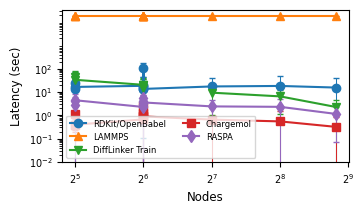

In [12]:
fig = make_scaling_plot(latencies, stddevs, logy=True)
fig.tight_layout(pad=0.2)
fig.savefig("figures/scaling-latencies.pdf")

In [13]:
latencies.head()

,nodes,path,RDKit/OpenBabel,LAMMPS,DiffLinker Train,Chargemol,RASPA
4,32,32-nodes_no-retrain,14.040884,18000.058084,NaN,0.367635,4.320696
5,32,32-nodes_repeat-1,25.464398,18000.061779,42.362898,1.128161,2.694254
11,32,32-nodes_repeat-2,16.521900,18000.058107,33.365839,0.395319,4.428928
0,64,64-nodes_repeat-2,18.436499,18000.060210,20.317799,0.668386,2.277868
2,64,64-nodes_no-stream,103.116890,18000.062349,NaN,2.635761,2.967038


In [14]:
def find_num(txt) -> int:
    """Finds and returns a number from a string.

    It will throw an error if there is not at least 1 number
    in the input string.

    If there are more than 1 numbers, the first/leftmost is returned.

    Example:
        >>> fund_num("hello I am 22 years old")
        42
    """
    if not isinstance(txt, str):
        txt = str(txt)
    result = re.findall(r"\d+", txt)
    if len(result) == 0:
        raise ValueError(f"String must have at least 1 number: '{txt}'.")
    return int(result[0])

,nodes,path,task,latency
0,32,32-nodes_no-retrain,Process Linkers,14.040884
1,32,32-nodes_repeat-1,Process Linkers,25.464398
2,32,32-nodes_repeat-2,Process Linkers,16.521900
3,64,64-nodes_repeat-2,Process Linkers,18.436499
4,64,64-nodes_no-stream,Process Linkers,103.116890


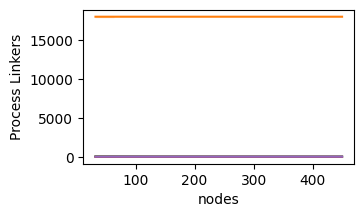

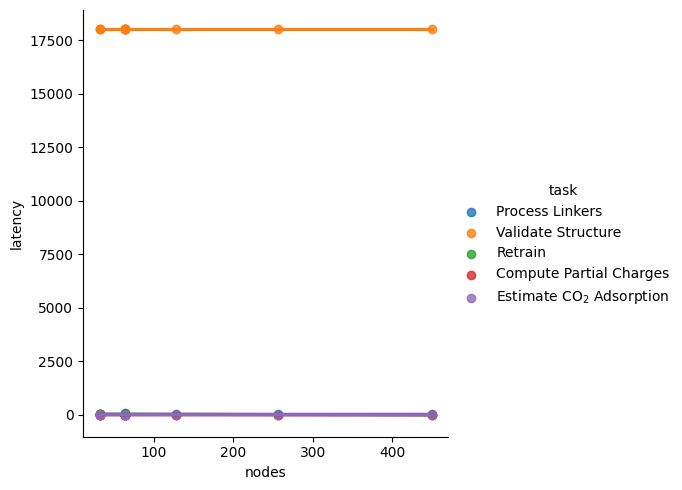

In [15]:
tmp = latencies.copy()
tmp = tmp.rename(
    columns={
        "RDKit/OpenBabel": "Process Linkers",
        "LAMMPS": "Validate Structure",
        "DiffLinker Train": "Retrain",
        "Chargemol": "Compute Partial Charges",
        "RASPA": "Estimate CO$_2$ Adsorption",
    }
)
tmp["nodes"] = tmp.nodes.map(find_num)
unmelted_tmp = tmp.copy()

id_vars = tmp.columns[:2]
value_vars = tmp.columns[2:]
tmp = tmp.melt(
    id_vars=id_vars, value_vars=value_vars, var_name="task", value_name="latency"
)
display(tmp.head())

nodes = sorted(tmp["nodes"].to_list())
fig, ax = plt.subplots(figsize=(3.5, 2))

# Drop the "nodes" and "path" column names

linestyles = ["-", "--", ":", "-.", (0, (3, 5, 1, 5, 1, 5))]
markerstyles = ["o", "^", "v", "s", "d"]


for i, val in enumerate(value_vars):
    sns.lineplot(
        unmelted_tmp,
        x="nodes",
        y=val,
        markers=markerstyles[i],
        ax=ax,
    )
plt.show()

sns.lmplot(
    tmp,
    x="nodes",
    y="latency",
    hue="task",
    # ax=ax,
)

ax.set_xscale("log", base=2)
plt.show()

# for i, kind in enumerate(value_vars):
#     print(i, kind)

# for i, kind in enumerate(kinds):
#     err = pd.DataFrame(stddevs[kind].to_list()).transpose()
#     ax.errorbar(
#         # x=[x*(1 + 0.03*i) for x in latencies['nodes']],
#         x=latencies["nodes"],
#         y=latencies[kind],
#         yerr=err,
#         label=kind,
#         # linestyle=linestyles[i],
#         marker=markerstyles[i],
#         capsize=2,
#         elinewidth=0.75,
#     )
# ax.set_ylabel("Latency (sec)", fontsize=8.5)
# ax.set_xlabel("Nodes", fontsize=8.5)
# if logy:
#     ax.set_yscale("log", base=10)
# ax.set_xscale("log", base=2)
# # ax.set_ylim([0, 60])

# handles, labels = ax.get_legend_handles_labels()
# # remove the errorbars
# handles = [h[0] for h in handles]
# # ax.legend(loc='upper center', fontsize=8, bbox_to_anchor=(0.5, -0.25), ncols=2)
# if not logy:
#     ax.set_xticks(nodes)
#     ax.set_xticklabels(nodes)
#     ax.legend(
#         handles, labels, loc="upper right", fontsize=6, bbox_to_anchor=(1.01, 1.01)
#     )
# else:
#     ax.set_yticks([0.01, 0.1, 1, 10, 100])
#     ax.legend(
#         handles,
#         labels,
#         loc="lower left",
#         fontsize=6,
#         bbox_to_anchor=(0, 0),
#         ncols=2,
#     )

# ax.tick_params(axis="x", labelsize=7)
# ax.tick_params(axis="y", labelsize=7)

# plt.show()

In [26]:
def make_scaling_plot(latencies, stddevs, logy=False):
    nodes = sorted(latencies["nodes"].to_list())

    fig, ax = plt.subplots(figsize=(4, 2))

    # Drop the "nodes" and "path" column names
    kinds = list(latencies.keys())[2:]

    linestyles = ["-", "--", ":", "-.", (0, (3, 5, 1, 5, 1, 5))]
    markerstyles = ["o", "^", "v", "s", "d"]

    for i, kind in enumerate(kinds):
        err = pd.DataFrame(stddevs[kind].to_list()).transpose()
        ax.errorbar(
            # x=[x*(1 + 0.03*i) for x in latencies['nodes']],
            x=latencies["nodes"],
            y=latencies[kind],
            yerr=err,
            label=kind,
            # linestyle=linestyles[i],
            marker=markerstyles[i],
            capsize=2,
            elinewidth=0.75,
        )
    ax.set_ylabel("Latency (sec)", fontsize=8.5)
    ax.set_xlabel("Nodes", fontsize=8.5)
    if logy:
        ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=2)
    # ax.set_ylim([0, 60])

    handles, labels = ax.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # ax.legend(loc='upper center', fontsize=8, bbox_to_anchor=(0.5, -0.25), ncols=2)
    if not logy:
        ax.set_xticks(nodes)
        ax.set_xticklabels(nodes)
        ax.legend(
            handles, labels, loc="upper right", fontsize=6, bbox_to_anchor=(1.01, 1.01)
        )
    else:
        ax.set_yticks([0.01, 0.1, 1, 10, 100])
        ax.legend(
            handles,
            labels,
            loc="upper center",
            fontsize=6,
            bbox_to_anchor=(0.5, 1.35),
            frameon=False,
            ncols=3,
        )

    ax.tick_params(axis="x", labelsize=7)
    ax.tick_params(axis="y", labelsize=7)

    return fig

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/Nathaniel/Development/GitHub/mof-generation-at-scale/scripts/sc25_artifacts/art1/../prod-runs/64-nodes_no-retrain


/var/folders/kn/2_n0f_tn41j9_rj_8lcvx4g00000gn/T/ipykernel_20852/4268000605.py:33: RuntimeWarning: Mean of empty slice.
  "DiffLinker Train": retrain_latencies.mean(),
/Users/Nathaniel/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/Nathaniel/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Nathaniel/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/Nathaniel/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 20%|██        | 1/5 [00:01<00:05,  1.44s/it

/Users/Nathaniel/Development/GitHub/mof-generation-at-scale/scripts/sc25_artifacts/art1/../prod-runs/128-nodes


 40%|████      | 2/5 [00:03<00:05,  1.86s/it]

/Users/Nathaniel/Development/GitHub/mof-generation-at-scale/scripts/sc25_artifacts/art1/../prod-runs/256-nodes


 60%|██████    | 3/5 [00:08<00:06,  3.07s/it]

/Users/Nathaniel/Development/GitHub/mof-generation-at-scale/scripts/sc25_artifacts/art1/../prod-runs/32-nodes_repeat-2


 80%|████████  | 4/5 [00:08<00:02,  2.09s/it]

/Users/Nathaniel/Development/GitHub/mof-generation-at-scale/scripts/sc25_artifacts/art1/../prod-runs/450-nodes


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


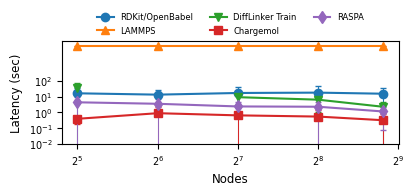

In [30]:
prod_runs_dir = Path("../prod-runs/")
prod_runs = {}
for dir in prod_runs_dir.rglob("*"):
    if "-nodes" not in dir.name:
        continue
    if dir.is_symlink() and not dir.exists():
        continue
    nodes = int(dir.name.split("-")[0])
    prod_runs[nodes] = dir.absolute()

latencies, stddevs = gather_scaling_latencies(prod_runs, stddev=True)
latencies.head()

fig = make_scaling_plot(latencies, stddevs, logy=True)
fig.tight_layout(pad=0.2)
# fig.savefig('figures/scaling-latencies.pdf')
plt.show()

In [ ]:
tmp_latencies = latencies.copy()
tmp_latencies["nodes"] = tmp.nodes.map(find_num)

tmp_stddevs = stddevs.copy()
# tmp_stddevs["nodes"] = tmp_stddevs.nodes.map(find_num)

fig = make_scaling_plot(tmp_latencies, tmp_stddevs, logy=True)
fig.tight_layout(pad=0.2)
# fig.savefig("figures/scaling-latencies.pdf")
plt.show()